## Moving Average (MA) Model

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Load your time series data (Apple stock prices)
apple_data = pd.read_csv('data/AAPL.csv', parse_dates=['Date'], index_col='Date')

apple_data

,Unnamed: 0,Open,High,Low,Close,Volume
Date,,,,,,
2017-01-09,0,27.407523,27.751425,27.405200,27.649183,134247600
2017-01-10,1,27.598065,27.739809,27.488855,27.677071,97848400
2017-01-11,2,27.591087,27.867603,27.558556,27.825777,110354400
2017-01-12,3,27.628269,27.721216,27.467936,27.709597,108344800
2017-01-13,4,27.677066,27.795573,27.607356,27.660801,104447600
...,...,...,...,...,...,...
2024-06-12,1868,207.369995,220.199997,206.899994,213.070007,198134300
2024-06-13,1869,214.740005,216.750000,211.600006,214.240005,97862700
2024-06-14,1870,213.850006,215.169998,211.300003,212.490005,70122700


### Check Stationarity

In [13]:
result = adfuller(apple_data['Close'])

print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

ADF Statistic: -0.16749913317425194, p-value: 0.9422863752570497


## Make data stationary

In [14]:
# Decompose the time series using additive model
decomposition = seasonal_decompose(apple_data['Close'], model='additive', period=365)

# Extract the trend component
trend = decomposition.trend

# Subtract the trend component from the original series
apple_data['Stationary'] = apple_data['Close'] - trend

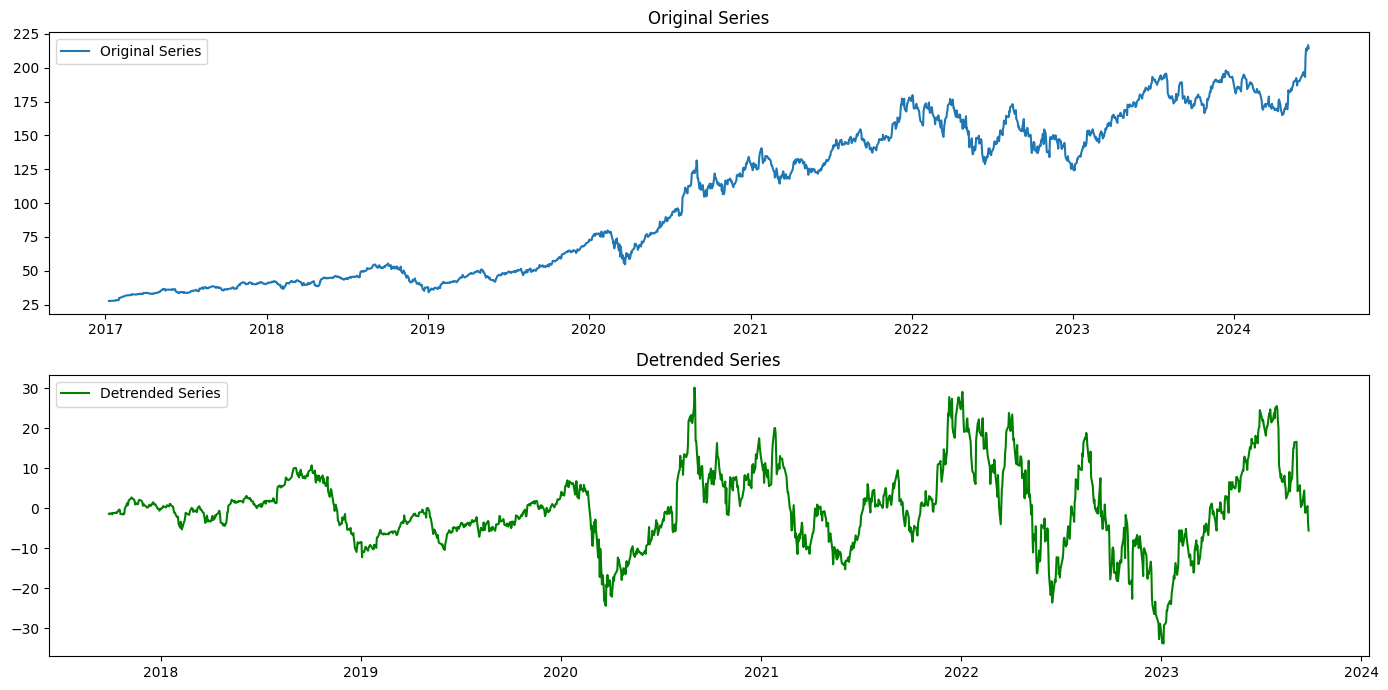

In [15]:
# Plot the original series, trend, and detrended series
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(apple_data['Close'], label='Original Series')
plt.title('Original Series')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(apple_data['Stationary'], label='Detrended Series', color='green')
plt.title('Detrended Series')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [16]:
# Apply again the ADF test
detrended_series_clean = apple_data['Stationary'].dropna()

result = adfuller(detrended_series_clean)

print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')

ADF Statistic: -4.131670100912887, p-value: 0.0008581452374582233


### Calculate Autocorrelation

<Figure size 1000x500 with 0 Axes>

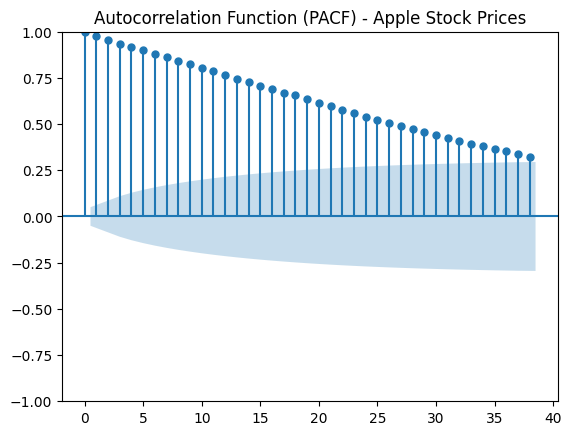

In [17]:
# Plot the PACF for Apple stock price series
plt.figure(figsize=(10, 5))
plot_acf(detrended_series_clean, lags=38)
plt.title('Autocorrelation Function (PACF) - Apple Stock Prices')
plt.show()

### Fit MA model

In [18]:
# Training and testing data

offset = int(len(detrended_series_clean)*0.9)
train_df = detrended_series_clean.iloc[:offset]
test_df = detrended_series_clean.iloc[offset:]

In [19]:
# Fit MA model
ma_model = ARIMA(train_df, order=(0,0,38)).fit()
print(ma_model.summary())

c:\Users\jacob\Documents\Simplicity\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jacob\Documents\Simplicity\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jacob\Documents\Simplicity\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Stationary   No. Observations:                 1358
Model:                ARIMA(0, 0, 38)   Log Likelihood               -2929.859
Date:                Fri, 11 Oct 2024   AIC                           5939.717
Time:                        01:14:43   BIC                           6148.268
Sample:                             0   HQIC                          6017.797
                               - 1358                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8678      1.403     -0.619      0.536      -3.617       1.881
ma.L1          0.9414      0.020     48.002      0.000       0.903       0.980
ma.L2          0.8864      0.027     32.460      0.0

In [21]:
# Forecast future values
forecast = ma_model.forecast(steps=100)
print(forecast)

1358   -12.439522
1359   -10.941651
1360   -11.274165
1361   -11.325737
1362   -11.483137
          ...    
1453    -0.867795
1454    -0.867795
1455    -0.867795
1456    -0.867795
1457    -0.867795
Name: predicted_mean, Length: 100, dtype: float64


c:\Users\jacob\Documents\Simplicity\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


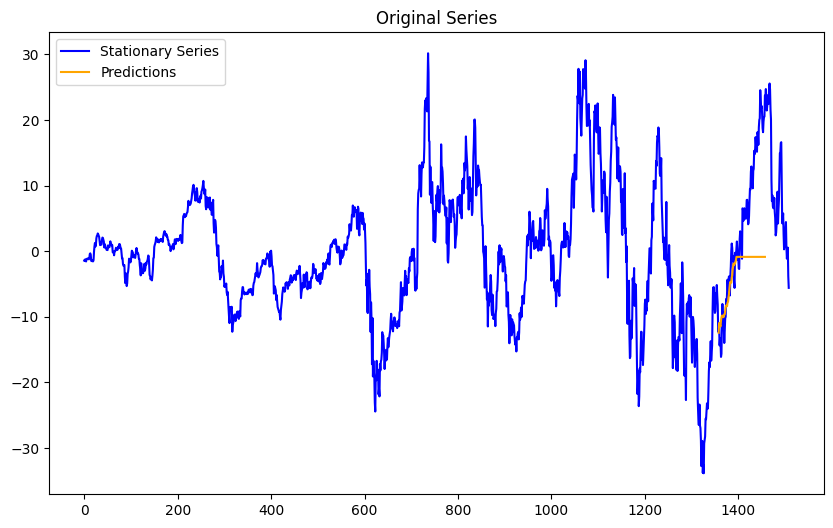

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(detrended_series_clean)), detrended_series_clean, label='Stationary Series', color='blue')
plt.plot(forecast.index, forecast, label='Predictions', color='orange')
plt.title('Original Series')
plt.legend(loc='best')
plt.show()


## Evaluating Model

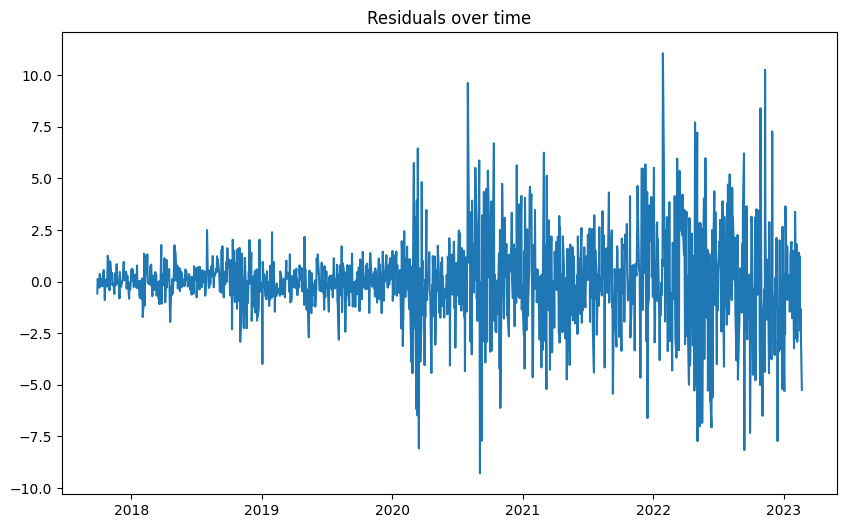

In [23]:
# Plotting Residual

residuals = ma_model.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals over time')
plt.show()

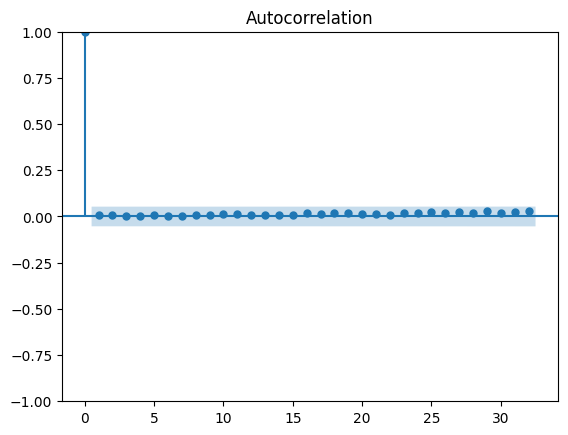

In [24]:
# Plotting Autocorrelation

plot_acf(residuals)
plt.show()

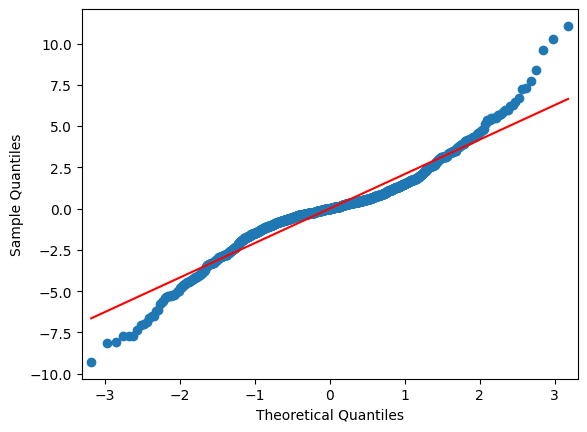

In [25]:
sm.qqplot(residuals, line='s')
plt.show()
